In [1]:
#%matplotlib inline
%matplotlib widget

In [2]:
# initialization
from rayoptics.environment import *

from rayoptics.oprops import doe

## Compute a thin achromat

In [3]:
def achromat(f, Va, Vb):
    phi_a = Va/(f*(Va - Vb))
    phi_b = Vb/(f*(Vb - Va))
    return phi_a, phi_b

# Create a new model

In [4]:
opm = OpticalModel()
sm  = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']
ar = opm['analysis_results']

## Define first order aperture and field for system

In [5]:
osp.pupil = PupilSpec(osp, key=['object', 'pupil'], value=5.0)
osp.field_of_view = FieldSpec(osp, key=['object', 'height'], flds=[0., 1.0])
osp.spectral_region = WvlSpec([(486.1327, 0.5), (587.5618, 1.0), (656.2725, 0.5)], ref_wl=1)

## Define interface and gap data for the sequential model

In [6]:
opm.radius_mode = False

sm.gaps[0].thi=1.0e10

sm.add_surface([0.0387, 1.0, 'N-BK7', 'Schott'])
s1 = sm.ifcs[sm.cur_surface]

sm.add_surface([0, 49.])
s2 = sm.ifcs[sm.cur_surface]
g2 = sm.gaps[sm.cur_surface]

## Update the model

In [7]:
opm.update_model()

In [8]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
    1:     0.038700      1.00000     N-BK7             1      2.5000
    2:     0.000000      49.0000       air             1      2.4709
  Img:     0.000000      0.00000                       1    0.010212


In [9]:
sm.gaps[1].medium.glass_code()

'517.642'

In [10]:
sm.rndx[1::1]

[[1.5223762897312285, 1.5168000345005885, 1.5143223472613747], [1.0, 1.0, 1.0]]

In [11]:
def refocus(opm):
    osp = opm.optical_spec
    pupil = [0., 1.]
    fi = 0
    wl = osp.spectral_region.reference_wvl
    fld, wvl, foc = osp.lookup_fld_wvl_focus(fi, wl)
    ray, ray_op, wvl = trace_base(opm, pupil, fld, wvl)
    ray = [RaySeg(*rs) for rs in ray]
    defoc = -ray[-1].p[1]/(ray[-2].d[1]/ray[-2].d[2])
    osp.defocus.focus_shift = defoc
    return defoc

In [12]:
pupil = [0., 1.]
fi = 0
wl = osp.spectral_region.reference_wvl
fld, wvl, foc = osp.lookup_fld_wvl_focus(fi, wl)
ray, ray_op, wvl = trace_base(opm, pupil, fld, wvl)
ray = [RaySeg(*rs) for rs in ray]
list_ray(ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      2.50000      0.12122     0.000000    -0.033067     0.999453      0.87926
  2:      0.00000      2.47093            0     0.000000    -0.050155     0.998741       49.062
  3:      0.00000      0.01021            0     0.000000    -0.050155     0.998741            0


In [13]:
defoc = -ray[-1].p[1]/(ray[-2].d[1]/ray[-2].d[2])
g2.thi += defoc
g2.thi

49.2033512137973

In [14]:
opm.update_model()

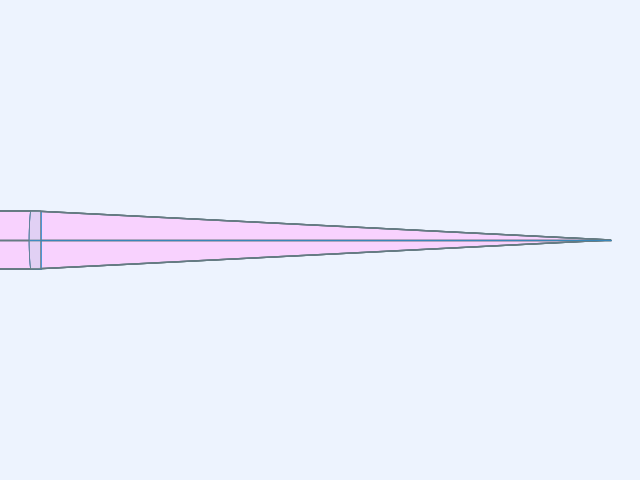

In [15]:
layout_plt = plt.figure(FigureClass=InteractiveLayout, opt_model=opm,
                        do_draw_rays=True, do_paraxial_layout=False).plot()

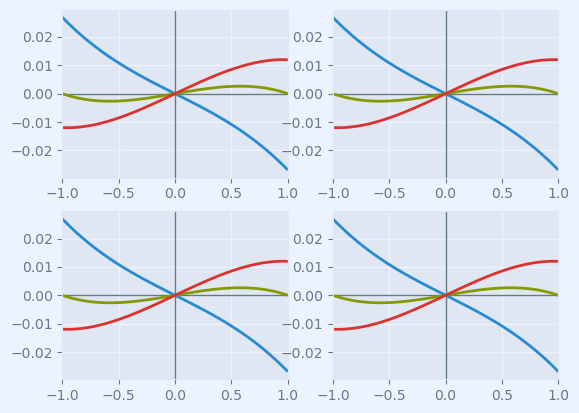

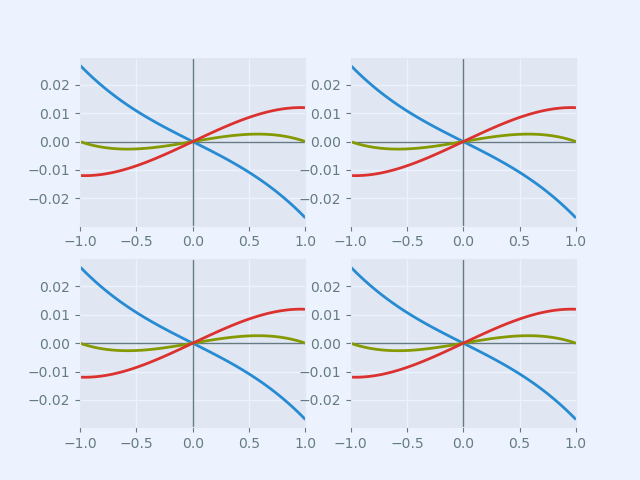

In [16]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray').plot()

## Compute hybrid achromat

In [17]:
V_doe = get_wavelength('d')/(get_wavelength('F') - get_wavelength('C'))
medium1 = sm.gaps[1].medium
nd = medium1.rindex(get_wavelength('d'))
nC = medium1.rindex(get_wavelength('C'))
nF = medium1.rindex(get_wavelength('F'))
V_lens = (nd - 1)/(nF - nC)
f = 50.
phi_doe, phi_lens = achromat(f, V_doe, V_lens)
f, V_doe, V_lens, phi_doe, phi_lens

(50.0,
 -3.4534059638015315,
 64.1673362374998,
 0.001021404335823771,
 0.01897859566417623)

In [18]:
c = phi_lens/(nd - 1);c

0.03672328637229341

In [19]:
s1.phase_element = doe.DiffractiveElement(ref_wl=get_wavelength('d'),
                                          coefficients=[-phi_doe],
                                          phase_fct=doe.radial_phase_fct)
s1.profile.c = phi_lens/(nd - 1)
g2.thi = 49.

In [20]:
opm.update_model()

In [21]:
sm.list_model()

              c            t        medium     mode   zdr      sd
  Obj:     0.000000  1.00000e+10       air             1      1.0000
    1:     0.038700      1.00000     N-BK7             1      2.5000
    2:     0.000000      49.0000       air             1      2.4680
  Img:     0.000000      0.00000                       1     0.24319


In [22]:
ray, ray_op, wvl = trace_base(opm, pupil, fld, wvl)
ray = [RaySeg(*rs) for rs in ray]
list_ray(ray)

            X            Y            Z           L            M            N               Len
  0:      0.00000      0.00000            0     0.000000     0.000000     1.000000        1e+10
  1:      0.00000      2.50000      0.12122     0.000000    -0.036422     0.999336      0.87936
  2:      0.00000      2.46797            0     0.000000    -0.055245     0.998473       49.075
  3:      0.00000     -0.24319            0     0.000000    -0.055245     0.998473            0


In [23]:
defoc = -ray[-1].p[1]/(ray[-2].d[1]/ray[-2].d[2])
g2.thi += defoc
g2.thi,defoc

(44.604773338483795, -4.395226661516202)

In [24]:
opm.update_model()

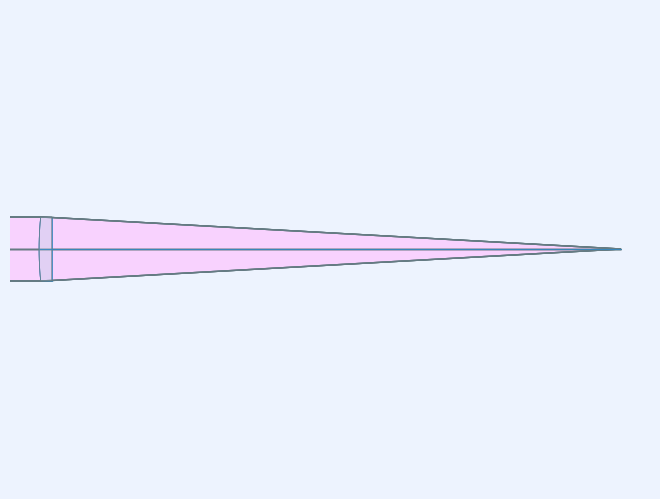

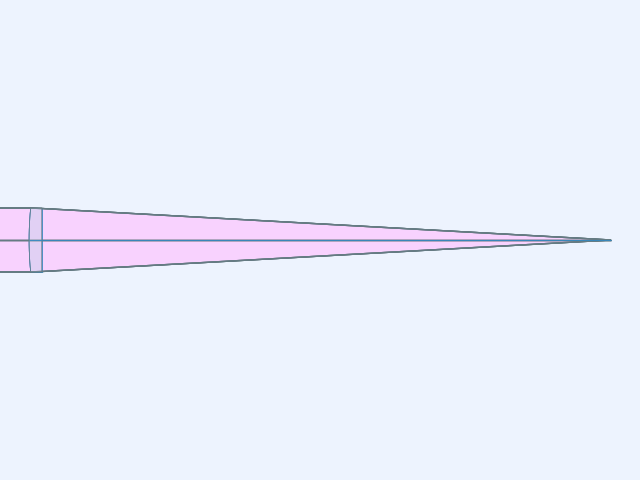

In [25]:
plt.figure(FigureClass=InteractiveLayout, opt_model=opm, do_draw_rays=True, do_paraxial_layout=False).plot()

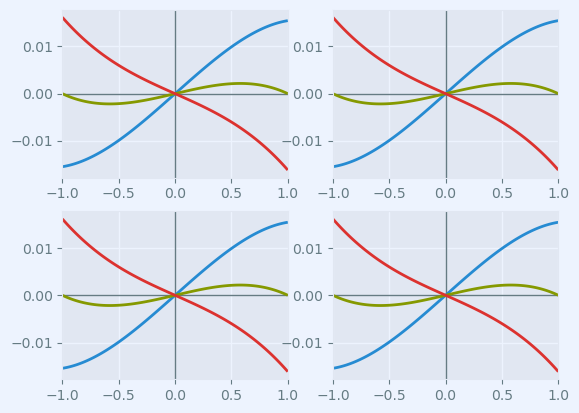

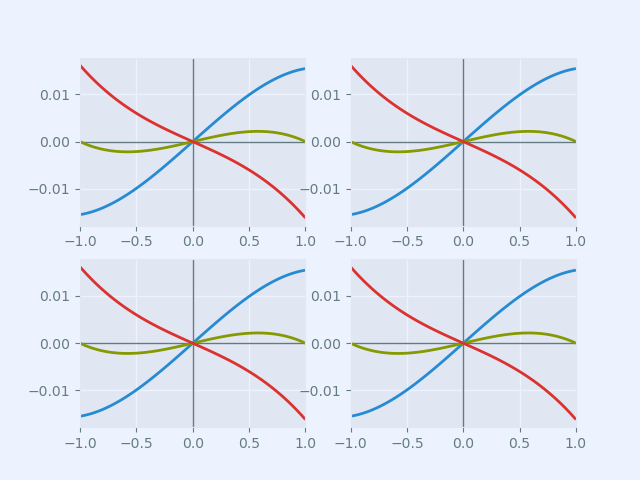

In [26]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='Ray').plot()

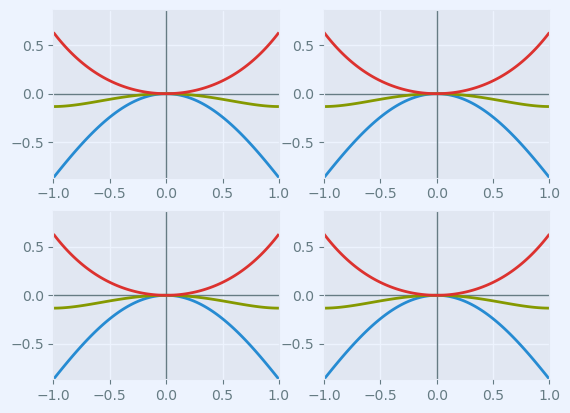

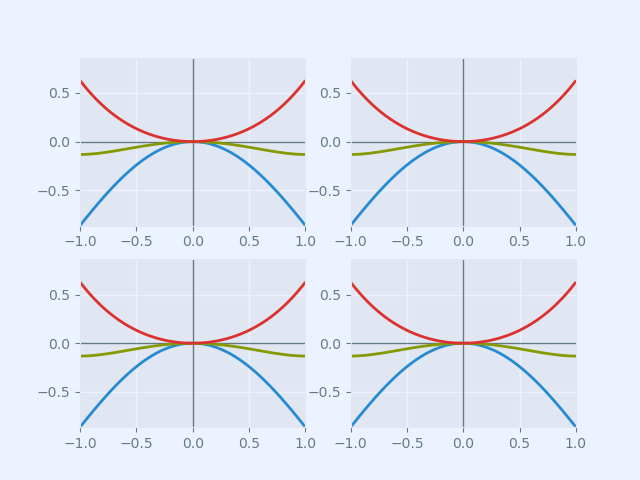

In [27]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm, data_type='OPD', scale_type=Fit.All_Same).plot()

## examine DOE phase calculation

In [28]:
pupil = [0., 1.]
fi = 0
wl = osp.spectral_region.reference_wvl
fld, wvl, foc = osp.lookup_fld_wvl_focus(fi, wl)
ray_d, ray_op_d, wvl_d, opd_d = trace_with_opd(opm, pupil, fld, get_wavelength('d'), foc)
ray_C, ray_op_C, wvl_C, opd_C = trace_with_opd(opm, pupil, fld, get_wavelength('C'), foc)
ray_F, ray_op_F, wvl_F, opd_F = trace_with_opd(opm, pupil, fld, get_wavelength('F'), foc)

In [29]:
z_dir = sm.z_dir[1]

d_idx = osp.spectral_region.wavelengths.index(get_wavelength('d'))
n_in_d = sm.rndx[d_idx][0]
n_out_d = sm.rndx[d_idx][1]
_, dW_d = rt.phase(sm.ifcs[1], ray_d[1][0], ray_d[0][1], ray_d[1][3], z_dir, wvl_d, n_in_d, n_out_d)

C_idx = osp.spectral_region.wavelengths.index(get_wavelength('C'))
n_in_C = sm.rndx[C_idx][0]
n_out_C = sm.rndx[C_idx][1]
_, dW_C = rt.phase(sm.ifcs[1], ray_C[1][0], ray_C[0][1], ray_C[1][3], z_dir, wvl_C, n_in_C, n_out_C)

F_idx = osp.spectral_region.wavelengths.index(get_wavelength('F'))
n_in_F = sm.rndx[F_idx][0]
n_out_F = sm.rndx[F_idx][1]
_, dW_F = rt.phase(sm.ifcs[1], ray_F[1][0], ray_F[0][1], ray_F[1][3], z_dir, wvl_F, n_in_F, n_out_F)

In [30]:
dW_d, dW_C, dW_F

(-0.0063837770990533395, -0.007130309281914657, -0.005281764058454732)

In [31]:
opd_d, opd_C, opd_F

(-7.774344455877685e-05, 0.0003695563147865611, -0.0005073365076580644)

In [32]:
ray_op_d, ray_op_C, ray_op_F

(1.3274319619096706, 1.324520982423901, 1.3334202507295416)

## save the model

In [33]:
opm.save_model('HybridAchromat')

## verify file can be restored and gives same results

In [34]:
notebook_pth = Path().resolve()

In [35]:
opm_res = open_model(notebook_pth/'HybridAchromat.roa')

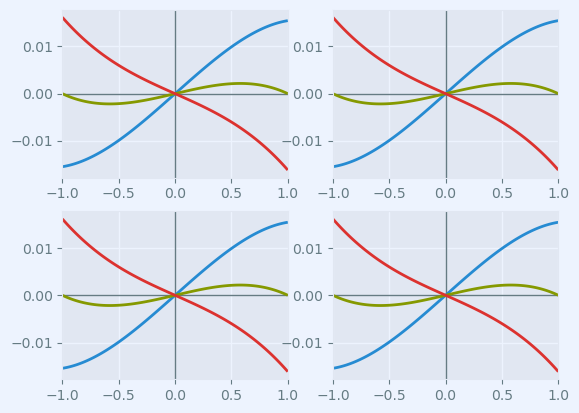

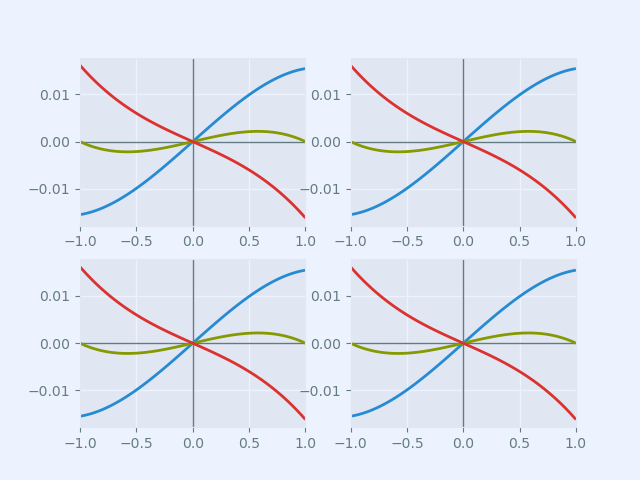

In [36]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm_res, data_type='Ray').plot()

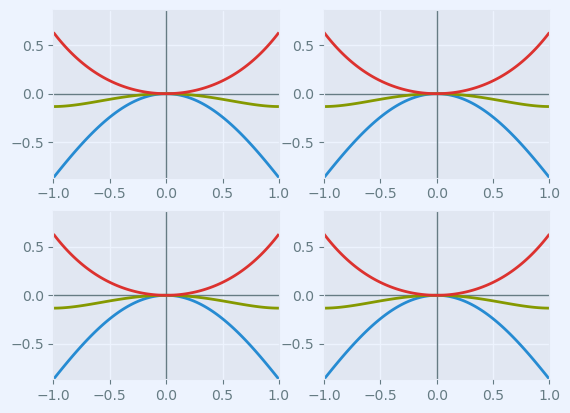

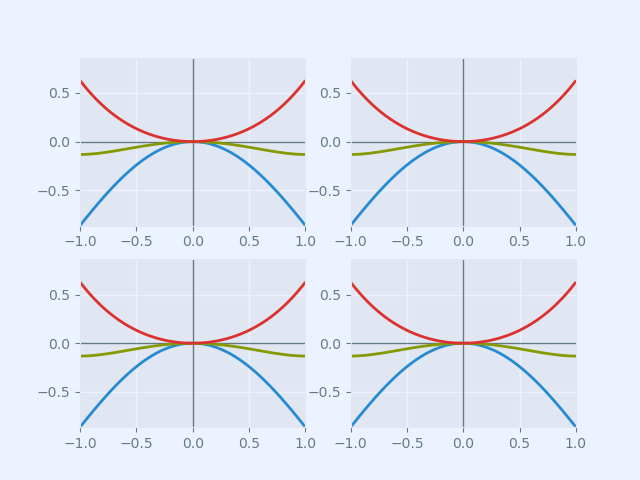

In [37]:
plt.figure(FigureClass=RayFanFigure, opt_model=opm_res, data_type='OPD', scale_type=Fit.All_Same).plot()